In [1]:
#Import packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.cluster.hierarchy import linkage, dendrogram



path = "../data/cleanData/normalizedFullData.csv"

In [68]:
dfNorm = pd.read_csv(path, index_col=False)
dfNorm=dfNorm.drop(['Unnamed: 0'], axis=1)
dfNorm=dfNorm.set_index(['County Name'])
dfNorm.head()

,"Population Estimates, July 1 2021, (V2021)",Persons under 5 years,Persons under 18 years,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,...,"Mean travel time to work (minutes), workers age 16 years+, 2017-2021","Median household income (in 2021 dollars), 2017-2021","Per capita income in past 12 months (in 2021 dollars), 2017-2021",Persons in poverty,"Total employer establishments, 2020","Total employment, 2020","Total annual payroll, 2020 ($1,000)","Population per square mile, 2020","Land area in square miles, 2020",Banned or not
County Name,,,,,,,,,,,,,,,,,,,,,
"Adams County, Ohio",-0.483125,-0.447412,-0.470140,-0.519097,-0.477279,-0.555122,-0.298633,-0.361370,-0.336760,-0.443469,...,2.859044,-1.299905,-1.256369,-0.377214,-0.466494,-0.426027,-0.384019,-0.518448,1.348417,0.0
"Allen County, Ohio",-0.146288,-0.116788,-0.123544,-0.148065,-0.157249,-0.166313,-0.081841,-0.148925,-0.256107,-0.443469,...,-1.338013,-0.427729,-0.476045,-0.067375,-0.103306,-0.075990,-0.107990,-0.090283,-0.696448,1.0
"Ashland County, Ohio",-0.370552,-0.355427,-0.367705,-0.377799,-0.364848,-0.393802,-0.293436,-0.373987,-0.304214,-0.183195,...,-0.149690,-0.177553,-0.415425,-0.362336,-0.342502,-0.307773,-0.302899,-0.359232,-0.465933,0.0
"Ashtabula County, Ohio",-0.165977,-0.165662,-0.168057,-0.121405,-0.176084,-0.124667,-0.236881,-0.020722,-0.297611,0.040764,...,0.254846,-0.872869,-0.833725,-0.075566,-0.195011,-0.253848,-0.270554,-0.328175,2.681437,0.0
"Athens County, Ohio",-0.326294,-0.403119,-0.422357,-0.414535,-0.324509,-0.352008,-0.270836,-0.235250,-0.176410,-0.134741,...,-0.731210,-1.087411,-1.171199,-0.144784,-0.343458,-0.350783,-0.338162,-0.359232,0.443611,0.0


### Boxplots

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1800x1440 with 0 Axes>

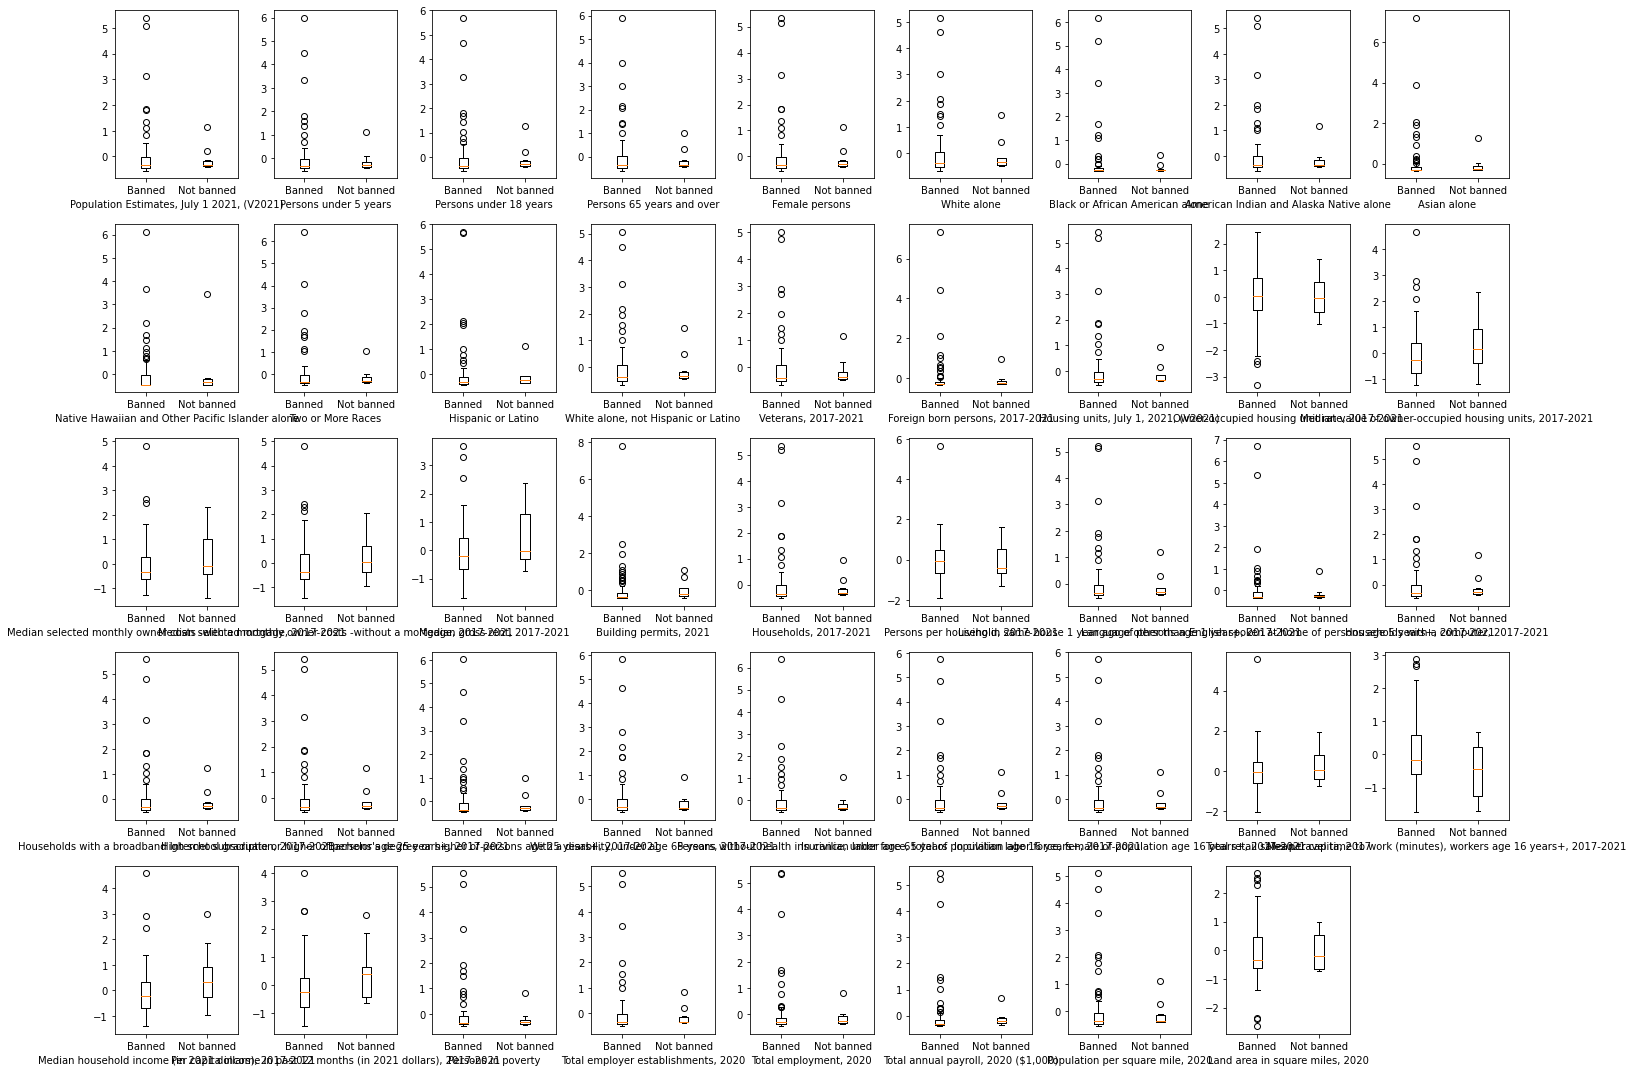

In [69]:
# visualizations to investigate what predictors may be relevant for detecting which counties are susceptible to implementing SB 52
plt.figure(figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of valid and fraudulent usage")
fig, ax = plt.subplots(7, 7, figsize=(20,15))

for x, col in enumerate(dfNorm):
    if col == 'Banned or not':
        continue
    
    ax = plt.subplot(5, 9, x+1)

    plt.boxplot([dfNorm[dfNorm['Banned or not'] == 0][col],dfNorm[dfNorm['Banned or not'] == 1][col]], 
                labels=['Banned', 'Not banned'])
    
    plt.xlabel(col)
    
        
    
plt.tight_layout()
    
plt.show



# Model #1: Building the clustering model

/Users/noorashrifeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/noorashrifeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/noorashrifeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/noorashrifeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warn

Text(0, 0.5, 'Inertia')

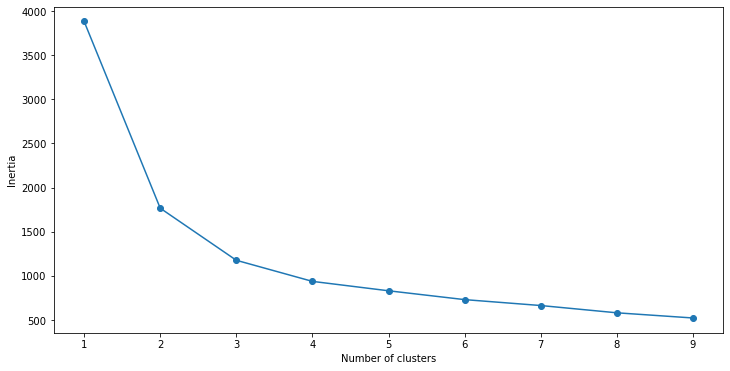

In [70]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(dfNorm)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Silhouette coefficient: metric used to evaluate the quality of clusters created by the algorithm.
- ranges from -1 to +1. The higher the silhouette score, the better the model.

In [72]:
# First, build a model with 4 clusters
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(dfNorm)

# Now, print the silhouette score of this model
print(f"The silhouette score of this model is about: {round(silhouette_score(dfNorm, kmeans.labels_, metric='euclidean'),2)}")

The silhouette score of this model is about: 0.43


/Users/noorashrifeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


### visualize the clusters
- find a way to limit which variables will be looked at

In [73]:
# clusters = kmeans.fit_predict(df)
# df["label"] = clusters

# fig = plt.figure(figsize=(21,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df.loc[df.label == 0, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 0], df["Total employment, 2020"][df.label == 0], c='blue', s=60)


# ax.scatter(df.loc[df.label == 1, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 1], df["Total employment, 2020"][df.label == 1], c='red', s=60)
# ax.scatter(df.loc[df.label == 2, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 2], df["Total employment, 2020"][df.label == 2], c='green', s=60)
# ax.scatter(df.loc[df.label == 3, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 3], df["Total employment, 2020"][df.label == 3], c='orange', s=60)
# ax.scatter(df.loc[df.label == 4, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 4], df["Total employment, 2020"][df.label == 4], c='yellow', s=60)

# ax.view_init(30, 185)
# plt.show()

# Model #2: Principal Component Analysis (PCA)

In [75]:
# Separate the features (X) from the target variable (y)
X = dfNorm.drop('Banned or not', axis=1)
y = dfNorm['Banned or not']

# Initialize PCA with the desired number of components
pca = PCA(n_components=3)

# Fit and transform the data to the chosen number of principal components
principal_components = pca.fit_transform(X)

# Print the explained variance for each principal component
print(pca.explained_variance_ratio_)

# Create a dataframe of the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Concatenate the principal components with the target variable
final_df = pd.concat([principal_df, y], axis=1)
final_df

[0.74359747 0.1186355  0.03394755]


,PC1,PC2,PC3,Banned or not
0,-3.120972,-1.849024,3.050991,NaN
1,-0.743986,-0.849321,-1.847952,NaN
2,-2.204194,-0.414945,0.071697,NaN
3,-1.186792,-1.719444,0.535189,NaN
4,-1.544693,-1.016669,-1.132746,NaN
...,...,...,...,...
"Wood County, Ohio",NaN,NaN,NaN,0.0
"Union County, Ohio",NaN,NaN,NaN,1.0
"Wyandot County, Ohio",NaN,NaN,NaN,0.0
"Summit County, Ohio",NaN,NaN,NaN,0.0


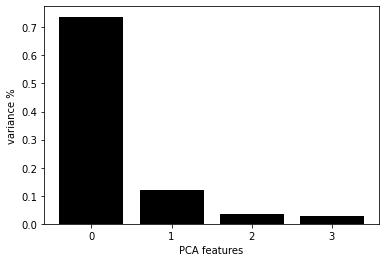

In [8]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(dfNorm)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

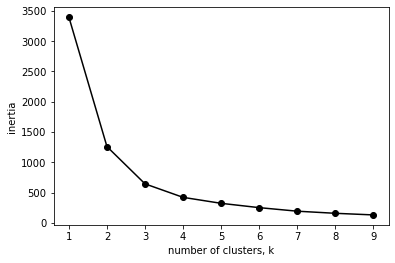

In [9]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### silhouette score

In [76]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:4])

print(silhouette_score(PCA_components.iloc[:,:4], model.labels_, metric='euclidean')) 

0.516362448891389


### visualize the clusters
- find a way to limit which variables will be looked at

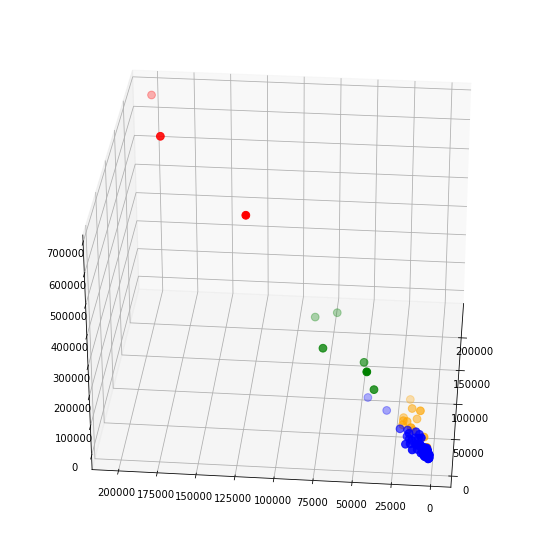

In [77]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
df["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[df.label == 0, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 0], df["Total employment, 2020"][df.label == 0], c='blue', s=60)


ax.scatter(df.loc[df.label == 1, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 1], df["Total employment, 2020"][df.label == 1], c='red', s=60)
ax.scatter(df.loc[df.label == 2, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 2], df["Total employment, 2020"][df.label == 2], c='green', s=60)
ax.scatter(df.loc[df.label == 3, 'Persons 65 years and over'], df["Persons in poverty"][df.label == 3], df["Total employment, 2020"][df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

# Cluster Analysis

In [78]:
path2 = "../data/cleanData/fullData.csv"

df = pd.read_csv(path2)
df=df.rename(columns = {'Unnamed: 0':'County Name'})
# Fill NA with zeros
df=df.fillna(0)
df

,County Name,"Population Estimates, July 1 2021, (V2021)",Persons under 5 years,Persons under 18 years,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,...,"Mean travel time to work (minutes), workers age 16 years+, 2017-2021","Median household income (in 2021 dollars), 2017-2021","Per capita income in past 12 months (in 2021 dollars), 2017-2021",Persons in poverty,"Total employer establishments, 2020","Total employment, 2020","Total annual payroll, 2020 ($1,000)","Population per square mile, 2020","Land area in square miles, 2020",Banned or not
0,"Adams County, Ohio",27542,1707.60,6665.16,5095.27,13798.54,26660.66,165.25,165.25,82.63,...,36.1,44467,24539,5205.44,385,4572,167427,47.1,583.87,0.0
1,"Allen County, Ohio",101670,6100.20,23587.44,18503.94,50021.64,84081.09,12912.09,305.01,915.03,...,19.5,55114,28671,15555.51,2286,45012,1983272,253.9,402.55,1.0
2,"Ashland County, Ohio",52316,2929.70,11666.47,10201.62,26524.21,50484.94,470.84,156.95,418.53,...,24.2,58168,28992,5702.44,1034,18234,701075,124.0,422.99,0.0
3,"Ashtabula County, Ohio",97337,5450.87,21414.14,19467.40,47889.80,90231.40,3796.14,389.35,486.68,...,25.8,49680,26777,15281.91,1806,24464,913850,139.0,702.07,0.0
4,"Athens County, Ohio",62056,2296.07,8998.12,8874.01,31090.06,56657.13,1799.62,248.22,1737.57,...,21.9,47061,24990,12969.70,1029,13265,469095,124.0,503.64,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,"Wood County, Ohio",132472,6623.60,26891.82,21327.99,66765.89,122801.54,3841.69,397.42,2649.44,...,20.7,66337,36047,14439.45,2701,57707,2719738,214.3,617.16,0.0
84,"Union County, Ohio",64971,3963.23,15852.92,8446.23,33460.06,58214.02,1754.22,129.94,3703.35,...,25.9,96634,44442,3573.40,1083,25265,1591247,145.4,431.76,1.0
85,"Wyandot County, Ohio",21708,1128.82,4840.88,4428.43,10897.42,21121.88,108.54,65.12,151.96,...,22.9,61626,30596,1714.93,494,9495,425207,53.8,406.88,0.0
86,"Summit County, Ohio",537633,29032.18,111827.66,101612.64,275805.73,415590.31,82257.85,1075.27,23118.22,...,23.3,63111,37373,67204.12,13210,246876,12462532,1309.2,412.79,0.0


In [79]:
pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

,County Name,"Population Estimates, July 1 2021, (V2021)",Persons under 5 years,Persons under 18 years,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,...,"Median household income (in 2021 dollars), 2017-2021","Per capita income in past 12 months (in 2021 dollars), 2017-2021",Persons in poverty,"Total employer establishments, 2020","Total employment, 2020","Total annual payroll, 2020 ($1,000)","Population per square mile, 2020","Land area in square miles, 2020",Banned or not,cluster
0,"Adams County, Ohio",27542,1707.60,6665.16,5095.27,13798.54,26660.66,165.25,165.25,82.63,...,44467,24539,5205.44,385,4572,167427,47.1,583.87,0.0,0
1,"Allen County, Ohio",101670,6100.20,23587.44,18503.94,50021.64,84081.09,12912.09,305.01,915.03,...,55114,28671,15555.51,2286,45012,1983272,253.9,402.55,1.0,0
2,"Ashland County, Ohio",52316,2929.70,11666.47,10201.62,26524.21,50484.94,470.84,156.95,418.53,...,58168,28992,5702.44,1034,18234,701075,124.0,422.99,0.0,0
3,"Ashtabula County, Ohio",97337,5450.87,21414.14,19467.40,47889.80,90231.40,3796.14,389.35,486.68,...,49680,26777,15281.91,1806,24464,913850,139.0,702.07,0.0,0
4,"Athens County, Ohio",62056,2296.07,8998.12,8874.01,31090.06,56657.13,1799.62,248.22,1737.57,...,47061,24990,12969.70,1029,13265,469095,124.0,503.64,0.0,0


## Compare attributes of the different clusters

In [80]:
# removed binary column
dfnew = df.drop(['Banned or not'], axis=1)
dfnew.head()

,County Name,"Population Estimates, July 1 2021, (V2021)",Persons under 5 years,Persons under 18 years,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,...,"Mean travel time to work (minutes), workers age 16 years+, 2017-2021","Median household income (in 2021 dollars), 2017-2021","Per capita income in past 12 months (in 2021 dollars), 2017-2021",Persons in poverty,"Total employer establishments, 2020","Total employment, 2020","Total annual payroll, 2020 ($1,000)","Population per square mile, 2020","Land area in square miles, 2020",cluster
0,"Adams County, Ohio",27542,1707.60,6665.16,5095.27,13798.54,26660.66,165.25,165.25,82.63,...,36.1,44467,24539,5205.44,385,4572,167427,47.1,583.87,0
1,"Allen County, Ohio",101670,6100.20,23587.44,18503.94,50021.64,84081.09,12912.09,305.01,915.03,...,19.5,55114,28671,15555.51,2286,45012,1983272,253.9,402.55,0
2,"Ashland County, Ohio",52316,2929.70,11666.47,10201.62,26524.21,50484.94,470.84,156.95,418.53,...,24.2,58168,28992,5702.44,1034,18234,701075,124.0,422.99,0
3,"Ashtabula County, Ohio",97337,5450.87,21414.14,19467.40,47889.80,90231.40,3796.14,389.35,486.68,...,25.8,49680,26777,15281.91,1806,24464,913850,139.0,702.07,0
4,"Athens County, Ohio",62056,2296.07,8998.12,8874.01,31090.06,56657.13,1799.62,248.22,1737.57,...,21.9,47061,24990,12969.70,1029,13265,469095,124.0,503.64,0


In [81]:

avg_df = dfnew.groupby(['cluster'], as_index=False).mean()
avg_df.head()

/var/folders/hb/wd37_kn90v3dbksczgwkk_m40000gn/T/ipykernel_27109/3964911416.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_df = dfnew.groupby(['cluster'], as_index=False).mean()


,cluster,"Population Estimates, July 1 2021, (V2021)",Persons under 5 years,Persons under 18 years,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,...,"Total retail sales per capita, 2017","Mean travel time to work (minutes), workers age 16 years+, 2017-2021","Median household income (in 2021 dollars), 2017-2021","Per capita income in past 12 months (in 2021 dollars), 2017-2021",Persons in poverty,"Total employer establishments, 2020","Total employment, 2020","Total annual payroll, 2020 ($1,000)","Population per square mile, 2020","Land area in square miles, 2020"
0,0,5.604617e+04,3148.298939,12370.476818,11025.566212,27975.927273,51792.496212,2431.354394,184.887727,402.602424,...,11016.484848,24.886364,56143.196970,28997.954545,7843.755152,1076.060606,17501.257576,7.164205e+05,121.318182,466.166212
1,1,1.132313e+06,68908.993333,251758.383333,179403.830000,582305.473333,738364.846667,307747.010000,3396.940000,48825.380000,...,16550.333333,23.200000,61396.000000,37585.000000,173688.903333,27319.666667,613282.000000,3.545482e+07,2433.900000,465.013333
2,2,4.303878e+05,24510.660000,94980.033333,78214.026667,220075.131667,340005.305000,63907.720000,1325.688333,11492.690000,...,15961.333333,22.916667,60945.166667,33648.833333,59474.180000,9041.166667,174493.000000,8.368200e+06,978.300000,457.688333
3,3,1.616695e+05,8598.633846,35761.560000,28003.125385,81107.419231,145163.069231,7120.373846,393.455385,5470.985385,...,17151.769231,25.546154,81093.153846,39720.230769,13180.150000,3194.307692,53210.461538,2.552820e+06,384.769231,457.743846


## visualizations of each variable

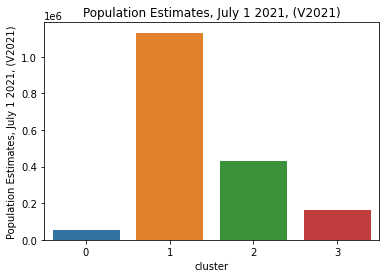

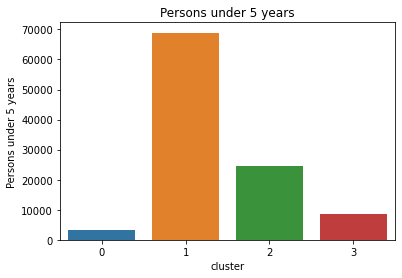

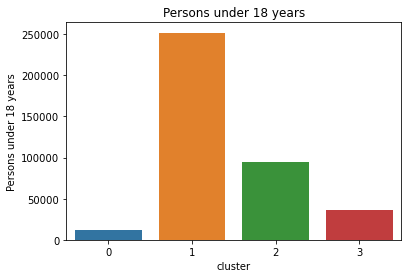

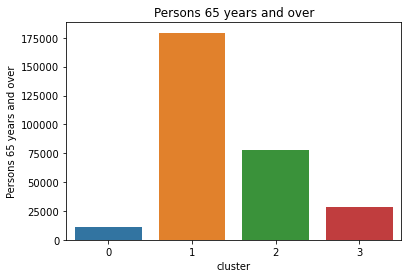

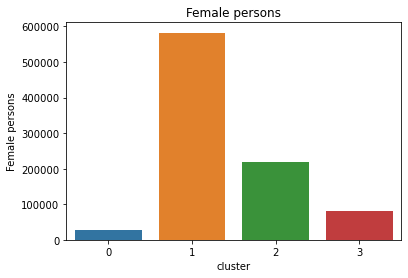

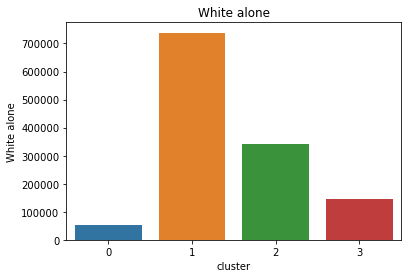

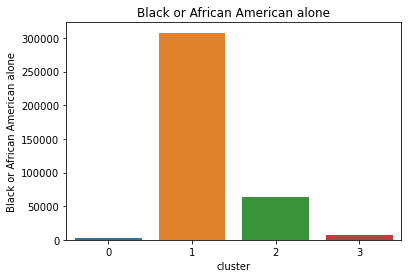

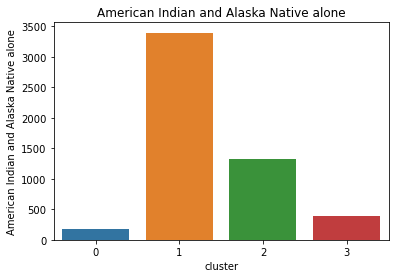

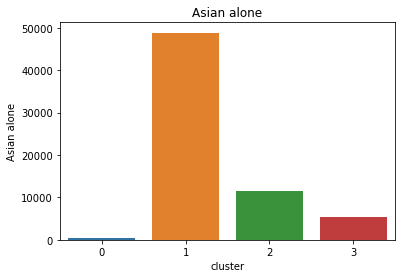

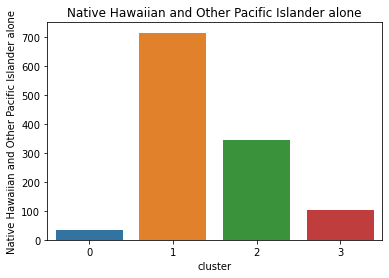

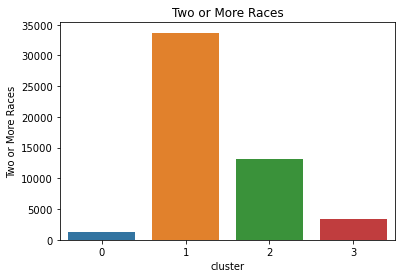

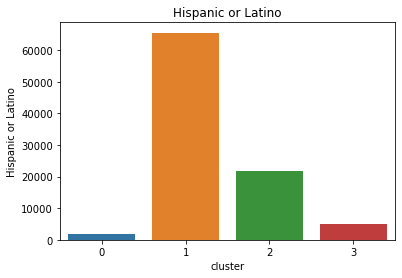

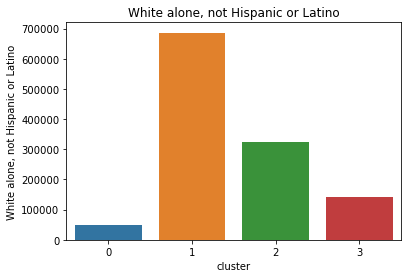

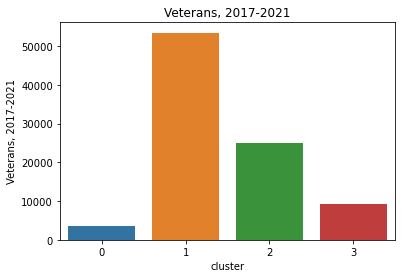

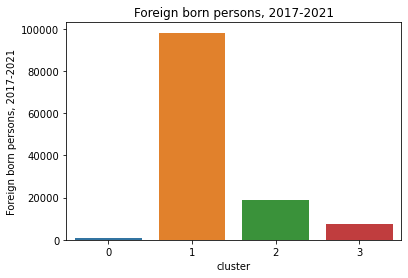

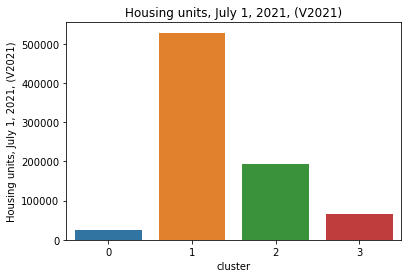

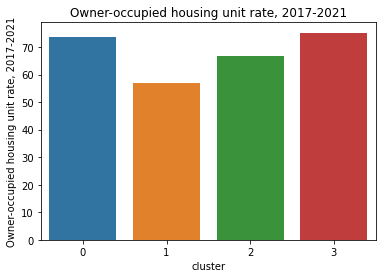

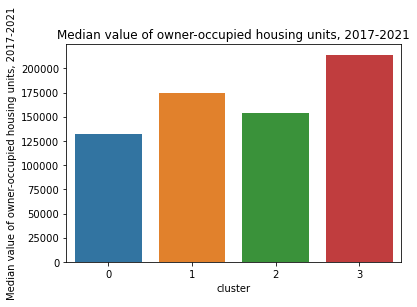

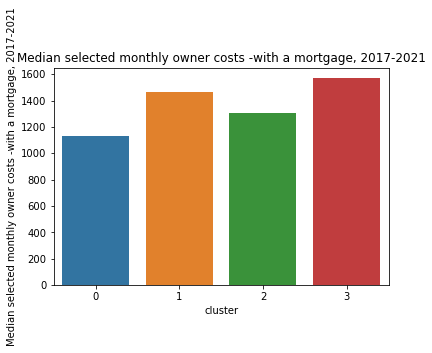

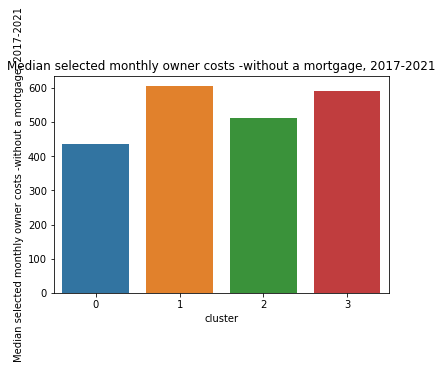

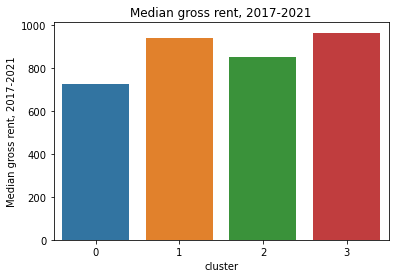

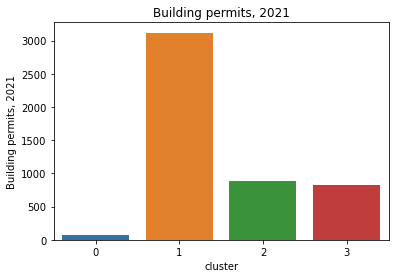

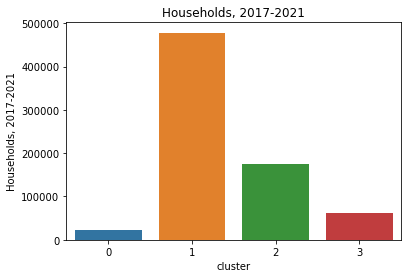

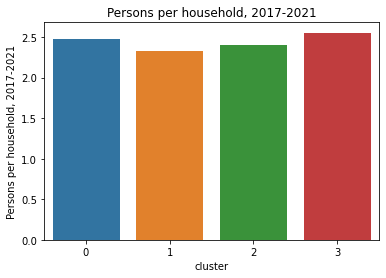

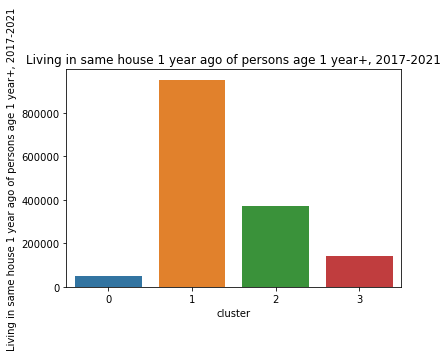

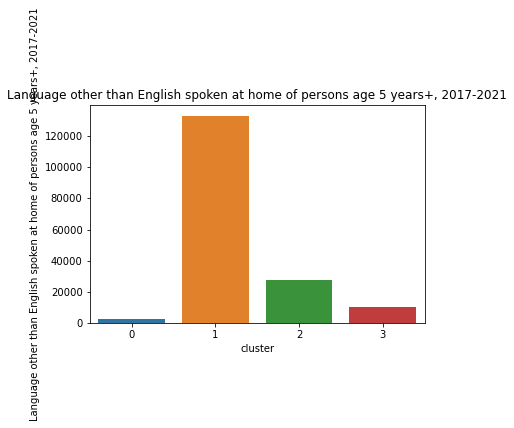

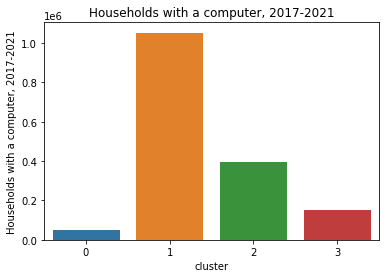

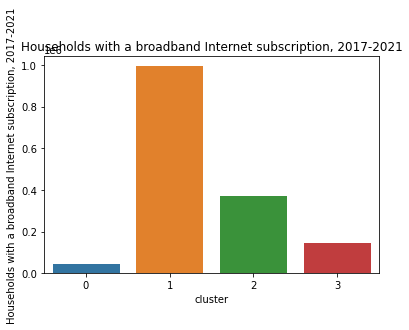

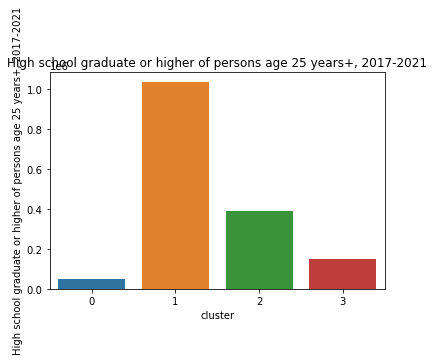

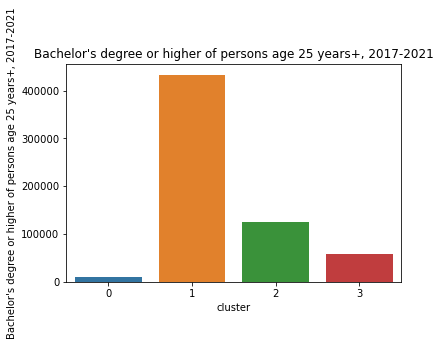

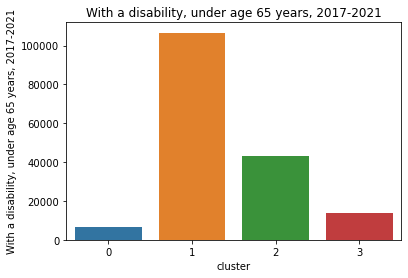

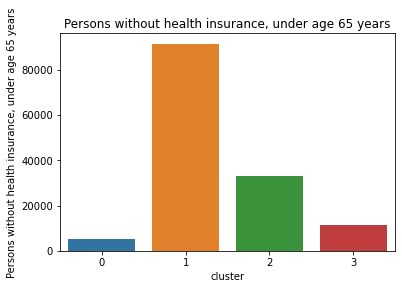

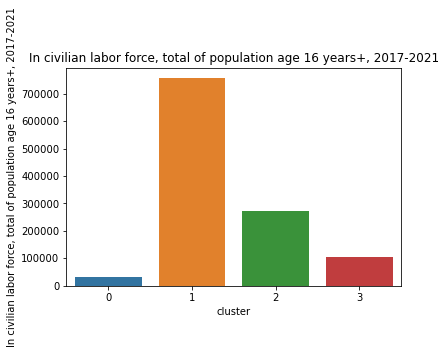

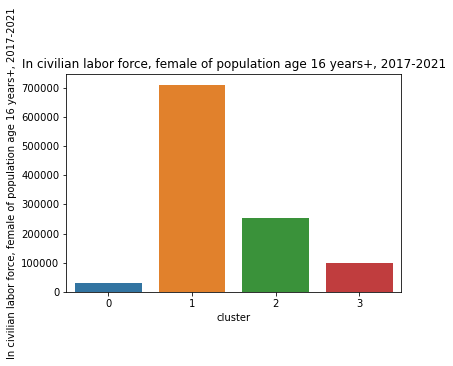

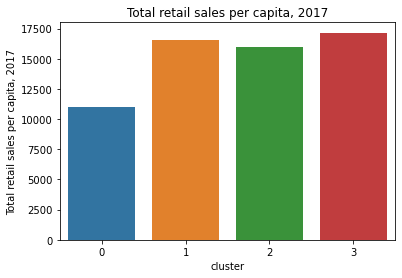

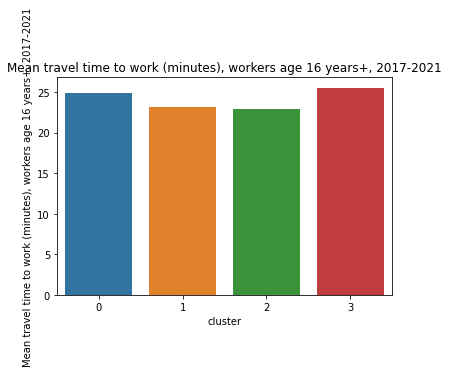

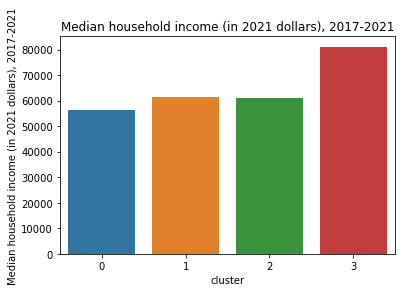

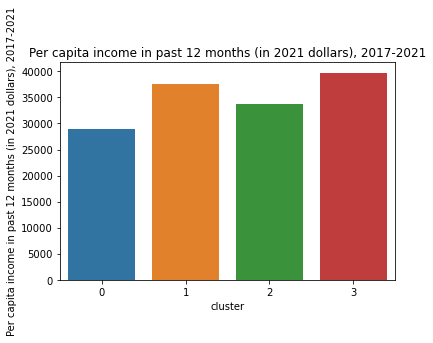

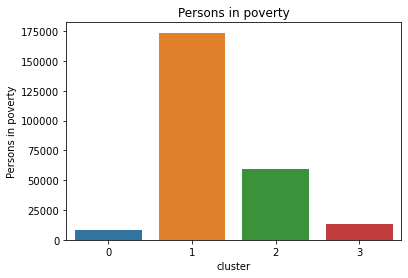

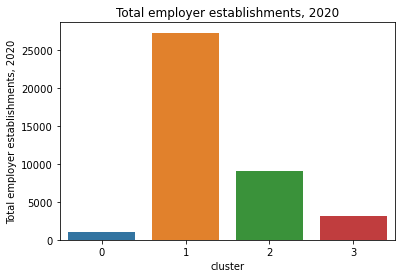

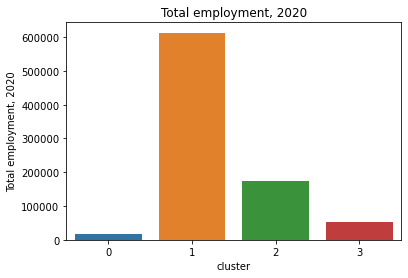

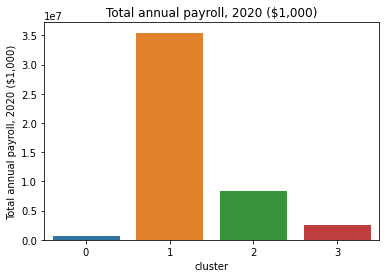

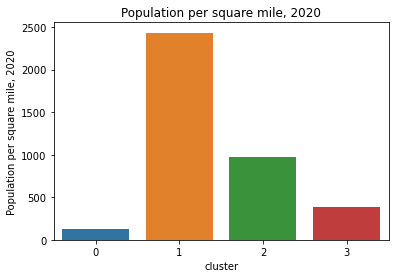

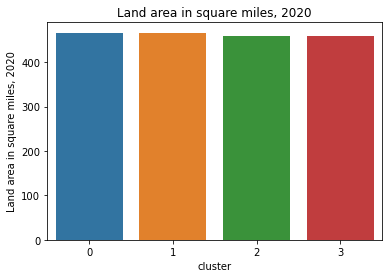

In [82]:
for col in avg_df.columns:
    if col == 'cluster':
        continue
    sns.barplot(x='cluster',y=col,data=avg_df)
    plt.title(col)
    plt.show()


# Banned or not break down

In [83]:
df2 = pd.DataFrame(df.groupby(['cluster','Banned or not'])['Banned or not'].count())
df2

Banned or not
cluster Banned or not               
0       0.0                       59
        1.0                        7
1       0.0                        3
2       0.0                        5
        1.0                        1
3       0.0                       11
        1.0                        2

In [ ]:
import matplotlib.pyplot as plt

# Define the categories and their colors
categories = [0, 1]
colors = ['#7bccc4', '#0868ac']

# Define the size of the dots
dot_size = 100

# Group the data by clusters and banned or not
grouped_data = df.groupby(['cluster', 'Banned or not']).size().reset_index(name='count')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
for i, cat in enumerate(categories):
    cat_data = grouped_data[grouped_data['Banned or not'] == cat]
    for j, row in cat_data.iterrows():
        x = row['cluster']
        y = j
        count = row['count']
        ax.scatter(x, y, s=dot_size*count, c=colors[i], edgecolors='none')

# Customize the plot
ax.set_xticks(range(df['cluster'].nunique()))
ax.set_xticklabels(df['cluster'].unique())
ax.set_yticks(range(len(grouped_data)))
# ax.set_yticklabels(grouped_data['Banned or not'].unique())
ax.set_ylabel('Banned or not')
ax.set_xlabel('Cluster')
ax.set_title('Dot Matrix Chart')
ax.legend(categories)

plt.show()


In [ ]:
grouped_data

# Dendrogram

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# select relevant columns for clustering
X = df.iloc[:, 1:46]

# calculate linkage matrix using ward method
Z = linkage(X, method='ward')

# create dendrogram
fig, ax = plt.subplots(figsize=(15, 20))
dendrogram(Z, labels=df['County Name'].values, orientation='right')

plt.title('Dendrogram of County Clustering')
plt.xlabel('Distance')
plt.ylabel('County')
plt.show()

## hierarchical clustering

In [ ]:
# Calculate distance matrix
dist_matrix = linkage(df, method='ward', metric='euclidean')

# Plot dendrogram
fig = plt.figure(figsize=(15, 10))
dendrogram(dist_matrix, labels=df.index, leaf_font_size=10)
plt.title('Country Demographics Dendrogram')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.show()

# CHATGPT: Cluster Analysis

In [ ]:
df

In [ ]:
df= df.set_index(['County Name'])
df

In [ ]:
dfBan = df[df['Banned or not'] == 1]
dfBan['County Name']

dfNoBan = df[df['Banned or not'] == 0]
dfNoBan['County Name']

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


# Separate the data into two groups based on the 'Banned or not' column (0 and 1)
group_0 = df[df['Banned or not'] == 0]
group_1 = df[df['Banned or not'] == 1]

# Remove the 'Banned or not' column from both groups
group_0.drop(['Banned or not'], axis=1, inplace=True)
group_1.drop(['Banned or not'], axis=1, inplace=True)


# Perform a hierarchical clustering using Euclidean distance as the distance metric and complete linkage as the linkage criterion
linkage_matrix = linkage(group_0, method='complete', metric='euclidean')

# Plot a dendrogram to determine the optimal number of clusters
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix)
plt.show()

# Use k-means clustering to group the data into the optimal number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(group_0)
group_0['cluster'] = kmeans.labels_

# adding county names to each group

# Identify which clusters contain counties with bans (1) and which clusters contain counties without bans (0)
banned_clusters = group_0[group_0.index.isin(group_1.index)]['cluster'].unique()
unbanned_clusters = group_0[~group_0.index.isin(group_1.index)]['cluster'].unique()

# Compare the counties in the clusters with no bans to those with bans to determine which counties are most similar
similar_counties = group_0[group_0['cluster'].isin(unbanned_clusters)].index.tolist()

# Print the most similar counties
print(similar_counties)
print(len(similar_counties))

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis and y-axis values
x = ['Counties with Bans', 'Counties without Bans']
y = [len(group_1), len(similar_counties)]

# Create a bar chart with dots
fig, ax = plt.subplots()
ax.barh(x, y, height=0.5, color=['red', 'blue'])
for i, v in enumerate(y):
    ax.text(v + 0.5, i - 0.15, str(v), color='black', fontweight='bold')
    for j in range(v):
        ax.scatter(v + 0.25, i, color='black', s=10)
        
# Set chart title and axis labels
ax.set_title('Counties with Bans vs. Counties without Bans')
ax.set_xlabel('Number of Counties')
ax.set_ylabel('')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of 0s and 1s to indicate which counties have bans
banned_list = [1 if index in group_1.index else 0 for index in group_0.index]

# Create a list of colors for the dot matrix chart
colors = ['red' if banned == 1 else 'blue' for banned in banned_list]

# Create the dot matrix chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(group_0.iloc[:, 0], group_0.iloc[:, 1], c=colors, alpha=0.5)

# Add the most similar counties as annotations to the chart
similar_counties = group_0[group_0['cluster'].isin(unbanned_clusters)].index.tolist()
for county in similar_counties:
    index = group_0.index.tolist().index(county)
    ax.annotate(county, (group_0.iloc[index, 0], group_0.iloc[index, 1]), fontsize=10)

# Add labels and title to the chart
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Dot Matrix Chart of Counties with Bans')

# Show the chart
plt.show()


In [ ]:
import math
import matplotlib.pyplot as plt

# Define the size of the chart and the number of dots per row/column
n_counties = len(similar_counties)
n_dots = int(math.sqrt(n_counties))

# Create a matrix of dots with different colors
dots = []
for i in range(n_dots):
    row = []
    for j in range(n_dots):
        county_index = i * n_dots + j
        if county_index < n_counties:
            if similar_counties[county_index] in group_1.index:
                color = 'blue'
            else:
                color = 'red'
            row.append(plt.scatter(j, i, color=color))
    dots.append(row)

# Add a legend to the chart
plt.legend((dots[0][0], dots[0][1]), ('Counties with bans', 'Counties without bans'), loc='upper left')

# Set the x and y limits of the plot and remove the tick marks
plt.xlim(-0.5, n_dots - 0.5)
plt.ylim(-0.5, n_dots - 0.5)
plt.xticks([])
plt.yticks([])

# Display the chart
plt.show()
